# Exercice B

Dans ce notebook, nous allons tenter de reconnaître les chiffre sur le data set http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits, à l'aide de méthodes pseudo-bayésiennes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact
from sklearn.model_selection import train_test_split

## Etape 1 : Récupérer les données

Dans un premier temps importe les données qui nous intéressent avec l'API scikit-learn

In [2]:
from sklearn.datasets import load_digits
data_raw = load_digits()
X = data_raw['data']
y = data_raw['target']

Inspection du dataset

In [3]:
@interact(num = range(X.shape[0]))
def afficher(num):
    plt.title(f"label = {y[num]}")
    return plt.imshow(X[num].reshape((8,8)));

interactive(children=(Dropdown(description='num', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

## Etape 2 : Stratégie de résolution

On va tenter de résoudre ce problème de classification à l'aide de méthodes pseudo-bayésienne.<br>
Pour cela on va utiliser un ensemble de classifieurs $\mathcal{F}$, muni d'une mesure de probabilité noté $\Pi_{\lambda}(\cdot|x)$ et calculée de la façon suivante : 
$$ \forall \Phi \in \mathcal{F}, \Pi_{\lambda}(\Phi|x) = K \exp(-\lambda R_n(\Phi))\Pi(\Phi)$$
où $K$ est une constante de normalisation, $R_n(\cdot)$ le risque empirique, $Pi(\cdot)$ la probabilité a priori sur les estimateurs, et $\lambda$ un hyperparamètre appelé température.<br>
L'estimateur mean pseudo-bayésien est alors le suivant : 
$$\widehat{\Phi_\lambda} = \mathbb{E}_{\Phi \sim \Pi_{\lambda}(\cdot|x)}\Phi$$
Afin de calculer cette espérence, on utilise une méthode de Monte Carlo (avec importance sampling), on a ainsi : 
$$\widehat{\Phi_\lambda} = \frac{1}{n}\sum_{i=1}^n\phi_i$$ où les $\phi_i$ sont échantillonés selon la loi 
$K \exp(-\lambda R_n(\cdot))\Pi(\cdot)$

Ainsi les déférentes étapes restantes sont : 
- Définir un ensemble $\mathcal{F}$ de classifieurs
- Définir une fonction loss et donc un risque empirique pour les classifieurs
- Définir un probabilité $\Pi(\cdot)$ a priori sur $\mathcal{F}$
- Etre capable d'échantillonner selon $K \exp(-\lambda R_n(\cdot))\Pi(\cdot)$
- Appliquer la méthode de Monte Carlo pour faire des prédictions

## Etape 3: Choix de l'espace des classifieurs

On décide d'utiliser des forêts aléatoires en temps que classifieurs. Ces classifieurs sont en effet naturellement adaptés à la classification multiclasse et ne sont pas parasités par des features peu informatifs. (a priori pas nécessaire de retravailler les features) De plus ces algorithmes sont plutôt rapide en temps de calcul ce qui est utile en pseudo bayésien.

In [4]:
from sklearn.ensemble import RandomForestClassifier

On va indéxer l'ensemble des algorithmes de de Random Forest par les hyper-paramètres suivants :
- nombre d'arbres(n_estimators)
- profondeur des arbres(max_depth)
- le nombre d'échantillion par noeuds(min_sample_split)<br>

Afin de favoriser les classifieurs avec une faible complexité on utilise la loi de probabilité suivante :
$$\Pi(Nb_{estimator}, Max_{depth}, Min_{SampleSplit}) = K\exp\left(-\left(\frac{Nb_{estimator}}{\lambda_{Nest}} +  \frac{Max_{depth}}{\lambda_{MaxDph}} + \frac{Min_{SampleSplit}}{\lambda_{MinSpS}}\right)\right)\mathcal{X}_{[Nb_{estimator}>0,Max_{depth}>0, Min_{SampleSplit}>0 ]}$$

Pour le risque empirique, on utilise, la norme l2

In [5]:
from sklearn.model_selection import cross_val_score

In [6]:
def risque_empirique(model, X, y):
    return cross_val_score(model, X, y, cv=3).mean()

## Etape 4 : Echantillonnage

Afin d'échantillonner l'ensemble $\mathcal{F}$ selon la probabilité $\Pi(\cdot|x)$ on utilise un algorithme de type MCMC.<br>
Dans notre cas, on va utiliser l'algorithme de Métropolis Hasting.<br>


In [7]:
# Hyperparamètres
Lambda = 10
Lambda_Nbest = 100
Lambda_Maxdp = 5
Lambda_MinSpS = 20

In [8]:
# Fonction de probabilité a priori définie plus tôt
def f_prior(x):
    k,l,m = x
    if k <= 1 or l<= 1 or m <= 2:
        return 0
    return np.exp(-(k/Lambda_Nbest + 
                    l/Lambda_Maxdp + 
                    m/Lambda_MinSpS
                   ))
# pseudo-posterior
def f_posterior(x,X_train,y_train):
    k,l,m = x
    if k <= 1 or l<= 1 or m <= 2:
        return 0
    model = RandomForestClassifier(n_estimators=int(k), max_depth=int(l), min_samples_split=int(m))
    return np.exp(-Lambda*risque_empirique(model, X_train, y_train))*np.exp(-(k/Lambda_Nbest + 
                    l/Lambda_Maxdp + 
                    m/Lambda_MinSpS
                   ))

In [9]:
# densité de probabilité de la loi selon laquelle on sait échantiollonner
q_ = lambda invS : lambda X, Mu : np.exp(-1/2*(X-Mu).T.dot(invS).dot(X-Mu))

# permet de générer des nombres selon une proba normale de moyenne Mu
gen_q_ = lambda s1,s2,s3 : lambda Mu : np.random.randn(3)*np.r_[s1,s2,s3] + Mu


# les paramètres de la loi d'échantiollonage (Matrice de covariance de la loi normale) 
#ont été fixés de façon à accélérer la vitesse de convergence de la Métropolis Hasting
invS = np.diag([0.25, 1, 1])
q = q_(invS)
gen_q = gen_q_(16, 1,1)

In [10]:
classifieurs = []
n = 10000
x0 = np.r_[2, 2, 3]
x_old = x0
Xlist = [x_old]
for i in range(n):
    if i%100==0:
        print(f"avancée {i/n*100:.2f}%", flush=True, end='\r')
    # candidat généré
    z = gen_q(x_old)
    rho = np.random.random()
    # test de rejet
    if rho < f_prior(z)/f_prior(x_old):
        x_old = z
    Xlist.append(x_old)

10.3244722353441

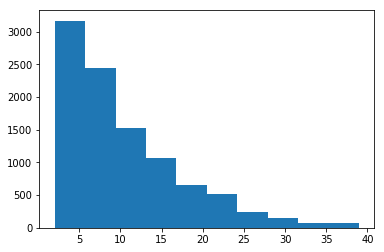

In [11]:
plt.hist(np.r_[Xlist][100:,2]);
np.r_[Xlist][100:,2].mean()

### Echantillionnage de l'espace des classifieurs

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
classifieurs = []
n = 1000
x0 = np.r_[2, 2, 3]
Lambda = 2
x_old = x0
Xlist = [x_old]
for i in range(n):
    if i%100==0:
        print(f"avancée {i/n*100:.2f}%", flush=True, end='\r')
    # candidat généré
    z = gen_q(x_old)
    rho = np.random.random()
    # test de rejet
    if rho < f_posterior(z,X_train,y_train)/f_posterior(x_old,X_train,y_train):
        x_old = z
        
    k,l,m = x_old
    # on ajoute le classifieur à la liste des classifieurs générés
    clf = RandomForestClassifier(n_estimators=int(k), max_depth=int(l), min_samples_split=int(m))
    clf.fit(X_train, y_train)
    classifieurs.append(clf)
    Xlist.append(x_old)

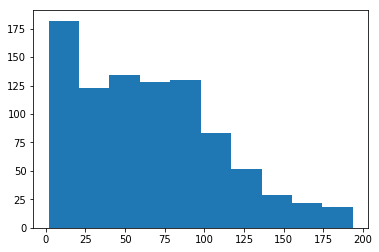

In [14]:
plt.hist(np.r_[Xlist][100:,0]);

### Evaluation des performances

In [15]:
from scipy import stats

In [16]:
def predict(classifieurs, X):
    ### Retourne une liste des prédictions des différents classifieurs
    return stats.mode(list(map(lambda x : x.predict(X),classifieurs)),axis = 0)[0]

In [28]:
### Calcul de la précision de l'estimateur MAP (vote majoritaire sur les classifieurs échantillonnés)
(predict(classifieurs,X_test) ==y_test).mean()

0.9111111111111111

In [29]:
### Même chose avec un burning de 100
(predict(classifieurs[100:],X_test) ==y_test).mean()

0.9138888888888889

In [35]:
### ... de 500
(predict(classifieurs[500:],X_test) ==y_test).mean()

0.9611111111111111

Comme attendu, avant d'atteindre la convergence les performances de la classification sont moins bonnes

## Comparaison avec une approche classique

On compare les performances avec celles d'un Random Forest dont on a optimisé les hyperparamètres avec une méthode de grid search classique.

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
param_grid = {'n_estimators' :[1,10,100],
             'max_depth' :[1,2,3,5,10,20],
             'min_samples_split' :[5,10,50]}
grid_search = GridSearchCV(RandomForestClassifier(),param_grid = param_grid)

In [20]:
grid_search.fit(X_train, y_train)

/home/kronert/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/kronert/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [1, 10, 100], 'max_depth': [1, 2, 3, 5, 10, 20], 'min_samples_split': [5, 10, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [21]:
grid_search.score(X_test, y_test)

0.9722222222222222

In [22]:
grid_search.best_params_

{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

On remarque que la méthode de classique donne de meilleurs résultats sur le test-set.<br>
Cela peut s'expliquer par le fait que l'algorithme de Métropolis-Hasting n'a pas vraiment eu le temps de converger. (temps de calcul trop long). Ou alors les choix de loi de probabilité a priori et les différents hyperparamètres n'étaient pas optimaux (par exemple la température).

(360,)